##### Redlining in Detroit

This notebook looks at the effects of the practice known as "redlining" in the Detroit area. A brief explanation of redlining from Wikipedia can be found below:

* "In the United States, redlining is a discriminatory practice in which services (financial and otherwise) are withheld from potential customers who reside in neighborhoods classified as 'hazardous' to investment; these neighborhoods have significant numbers of racial and ethnic minorities, and low-income residents. While the most well-known examples involve denial of credit and insurance, denial of healthcare and the development of food deserts in minority neighborhoods have also been attributed to redlining in many instances. In the case of retail businesses like supermarkets, the purposeful construction of stores impractically far away from targeted residents results in a redlining effect."
* https://en.wikipedia.org/wiki/Redlining

Using publically available data from 1939 that divided Detroit into 238 distircts that were largely determined by the race of its residents. Each district was given one of four rankings: "Best," "Still Desirable," "Definitely Declining," or "Hazardous." In this notebook I will plot the 1939 districts using their latitude and longitude data and then use the US Census Bureau's API to find the contemporary income data to see how these districts may have changed.

The historical data used for this project can be found here: https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/MIDetroit1939.geojson

In [1]:
import csv
import json
from matplotlib.path import Path
import matplotlib.patches as patches
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as random
import numpy as np
import re
import collections
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns

In [2]:
data = requests.get('https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/MIDetroit1939.geojson').json()

# extracting list of all 238 districts in this dataset
# each district is a dict within this list
districts = data['features']

In [3]:
# creating a class for the ditricts
class DetroitDistrict():
    def __init__(self, Coordinates=None, HolcGrade=None, HolcColor=None, name=None, 
            QualitativeDescription=None, RandomLat=None, RandomLong=None, MedianIncome=None, 
            CensusTract=None, IncomeColor=None, diction=None):
        self.Coordinates = diction['geometry']['coordinates'][0][0]
        self.HolcGrade = diction['properties']['holc_grade']
        self.name = name
        self.QualitativeDescription= diction['properties']['area_description_data']['8']
        self.RandomLat = RandomLat
        self.RandomLong = RandomLong
        self.MedianIncome = MedianIncome
        self.CensusTract = CensusTract
        self.IncomeColor = IncomeColor
        

        if diction['properties']['holc_grade'] == 'A':
            self.HolcColor = 'darkgreen'
        elif diction['properties']['holc_grade'] == 'B':
            self.HolcColor = 'cornflowerblue'
        elif diction['properties']['holc_grade'] == 'C':
            self.HolcColor = 'gold'
        elif diction['properties']['holc_grade'] == 'D':
            self.HolcColor = 'maroon'
        else:
            self.HolcColor = None

In [4]:
# creating list of each district as an instance of DetroitDistrict class
Districts = [DetroitDistrict(diction=dist) for dist in data['features']]

In [5]:
# setting district name numerically
for i in range(len(Districts)):
    Districts[i].name = i+1

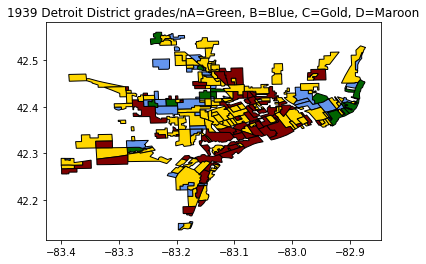

In [6]:
# plotting the districts
fig, ax = plt.subplots()
for dist in Districts:
    ax.add_patch(patches.Polygon(dist.Coordinates, facecolor=dist.HolcColor, \
                                 edgecolor='black'))
    plt.title('1939 Detroit District grades/nA=Green, B=Blue, C=Gold, D=Maroon')
    ax.autoscale()
    plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [7]:
random.seed(17)
# setting start, stop, and step for x and y axes
xgrid = np.arange(-83.5,-82.8,.004)
ygrid = np.arange(42.1, 42.6, .004)

# making grid with above axes (2 dimensions)
xmesh, ymesh = np.meshgrid(xgrid,ygrid)

# stacks all values vertically (have to collapse xmesh and ymesh to 1 dimension to do this
points = np.vstack((xmesh.flatten(),ymesh.flatten())).T

for j in Districts:
    p = Path(j.Coordinates) # assigning the coordinates from each district to p
    grid = p.contains_points(points) # grid contains every coordinate

    # selecting a random point for each dist from list of coordinates
    point = points[random.choice(np.where(grid)[0])]
    # assigning that random point to the district's RandomLong and RandomLat attributes
    j.RandomLong = point[0]
    j.RandomLat = point[1]

In [8]:
# finding and assigning tract numbers to each district
for dist in Districts:
    tract_url = f'https://geo.fcc.gov/api/census/area?lat={dist.RandomLat}&lon={dist.RandomLong}&censusYear=2010&format=json'
    tract_json = requests.get(tract_url).json()
    # block_fips has state, county, tract, and other info all in one number
    # first 2 digits = state, next 3 = county, next 5 = tract
    dist.CensusTract = tract_json['results'][0]['block_fips'][5:11]
    dist.County = tract_json['results'][0]['county_fips'][2:]

In [9]:
# finding and assigning median household income for each district
cens_key = '7ef49c95488ceea818995ebf5f6eb3c2dc354ec9'
state_fips = 26
median_income = 'B19013_001E'
for dist in Districts:
    # need to use state, county, tract
    search_url = f'https://api.census.gov/data/2018/acs/acs5?get={median_income}&for=tract:{dist.CensusTract}&in=state:{state_fips}&in=county:{dist.County}&key={cens_key}'

    income = requests.get(search_url).json()
    dist.MedianIncome = income[1][0]

In [10]:
a_incomes = np.array([])
b_incomes = np.array([])
c_incomes = np.array([])
d_incomes = np.array([])
A_dists = []
B_dists = []
C_dists = []
D_dists = []
for dist in Districts:
    if dist.HolcGrade == 'A':
        a_incomes = np.append(a_incomes, float(dist.MedianIncome))
        A_dists.append(dist)
    elif dist.HolcGrade == 'B':
        b_incomes = np.append(b_incomes, float(dist.MedianIncome))
        B_dists.append(dist)
    elif dist.HolcGrade == 'C':
        c_incomes = np.append(c_incomes, float(dist.MedianIncome))
        C_dists.append(dist)
    elif dist.HolcGrade == 'D':
        d_incomes = np.append(d_incomes, float(dist.MedianIncome))
        D_dists.append(dist)

In [11]:
# calculating mean and median 
A_mean_income = np.mean(a_incomes)
A_median_income = np.median(a_incomes)

B_mean_income = np.mean(b_incomes)
B_median_income = np. median(b_incomes)

C_mean_income = np.mean(c_incomes)
C_median_income = np. median(c_incomes)

D_mean_income = np.mean(d_incomes)
D_median_income = np.median(d_incomes)

print(f'A mean income: {round(A_mean_income, 2)}\
    \nB mean Income: {round(B_mean_income, 2)}\
    \nC mean income: {round(C_mean_income, 2)}\
    \nD mean income: {round(D_mean_income, 2)}\n')
print(f'A median income: {A_median_income}\nB median income: {B_median_income}\
    \nC median income: {C_median_income}\nD median income: {D_median_income}')

A mean income: 98330.6    
B mean Income: 65857.95    
C mean income: 42635.32    
D mean income: 30117.65

A median income: 113220.0
B median income: 70125.0    
C median income: 34193.5
D median income: 25463.0


In [12]:
# creating single string for each grade  
A_string = "".join([dist.QualitativeDescription for dist in A_dists])
B_string = "".join([dist.QualitativeDescription for dist in B_dists])
C_string = "".join([dist.QualitativeDescription for dist in C_dists])
D_string = "".join([dist.QualitativeDescription for dist in D_dists])

In [13]:
# splitting string into words
A_split = re.split(r"[\b\W\b]+", A_string)
B_split = re.split(r"[\b\W\b]+", B_string)
C_split = re.split(r"[\b\W\b]+", C_string)
D_split = re.split(r"[\b\W\b]+", D_string)

In [14]:
# removing stop words
STOP_WORDS.add('area')
def remove_stop_words(words):
    no_stop = []
    for word in words:
        if word.lower() not in STOP_WORDS:
            no_stop.append(word.lower())
    return no_stop

A_no_stop = remove_stop_words(A_split)
B_no_stop = remove_stop_words(B_split)
C_no_stop = remove_stop_words(C_split)
D_no_stop = remove_stop_words(D_split)

In [15]:
# finding 10 most common words
A_10_Most_Common = collections.Counter(A_no_stop).most_common(10)
B_10_Most_Common = collections.Counter(B_no_stop).most_common(10)
C_10_Most_Common = collections.Counter(C_no_stop).most_common(10)
D_10_Most_Common = collections.Counter(D_no_stop).most_common(10)

In [16]:
print(f'These are the most common words in A districts:\n{A_10_Most_Common}\n')
print(f'These are the most common words in B districts:\n{B_10_Most_Common}\n')
print(f'These are the most common words in C districts:\n{C_10_Most_Common}\n')
print(f'These are the most common words in D districts:\n{D_10_Most_Common}\n')

These are the most common words in A districts:
[('section', 13), ('good', 12), ('neighborhood', 12), ('high', 11), ('houses', 11), ('detroit', 11), ('000', 10), ('class', 10), ('development', 9), ('city', 8)]

These are the most common words in B districts:
[('houses', 28), ('good', 27), ('streets', 21), ('section', 21), ('transportation', 19), ('new', 18), ('developed', 17), ('singles', 17), ('construction', 16), ('east', 16)]

These are the most common words in C districts:
[('houses', 81), ('flats', 76), ('singles', 71), ('000', 69), ('explanation', 64), ('sheet', 64), ('grade', 62), ('2', 61), ('descriptions', 58), ('3rd', 54)]

These are the most common words in D districts:
[('sheet', 46), ('explanation', 45), ('descriptions', 42), ('flats', 41), ('2', 33), ('4th', 31), ('grade', 29), ('houses', 27), ('type', 22), ('street', 20)]



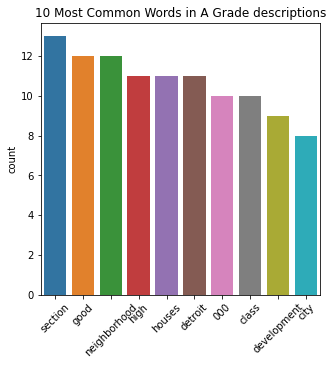

In [17]:
# visualizing the most common words

# Grade A
plt.figure(figsize=(5,5))
sns.countplot(x=A_no_stop, order=[counted[0] for counted in collections.Counter(A_no_stop).most_common(10)])
plt.xticks(rotation=45)
plt.title('10 Most Common Words in A Grade descriptions')
plt.show()

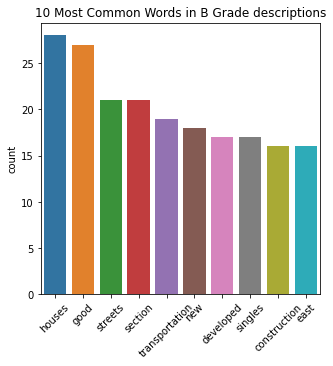

In [18]:
# Grade B
plt.figure(figsize=(5,5))
sns.countplot(x=B_no_stop, order=[counted[0] for counted in collections.Counter(B_no_stop).most_common(10)])
plt.xticks(rotation=45)
plt.title('10 Most Common Words in B Grade descriptions')
plt.show()

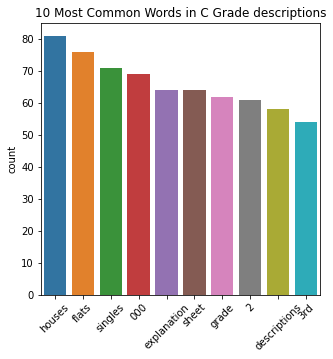

In [19]:
# Grade C
plt.figure(figsize=(5,5))
sns.countplot(x=C_no_stop, order=[counted[0] for counted in collections.Counter(C_no_stop).most_common(10)])
plt.xticks(rotation=45)
plt.title('10 Most Common Words in C Grade descriptions')
plt.show()

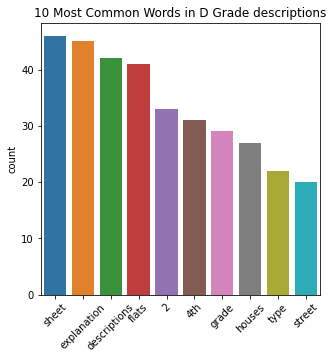

In [20]:
# Grade D
plt.figure(figsize=(5,5))
sns.countplot(x=D_no_stop, order=[counted[0] for counted in collections.Counter(D_no_stop).most_common(10)])
plt.xticks(rotation=45)
plt.title('10 Most Common Words in D Grade descriptions')
plt.show()

In [21]:
# getting all income values and splitting them into 4 roughly equal arrays
median_incomes = np.array([])
for dist in Districts:
    median_incomes = np.append(median_incomes, float(dist.MedianIncome))

# sorting then splitting values into 4 bins
median_incomes = np.sort(median_incomes)
low, low_med, high_med, high = np.array_split(median_incomes, 4)

print(f'1 min: {min(high)}')
print(f'2 max: {max(high_med)}')
print(f'2 min: {min(high_med)}')
print(f'3 max: {max(low_med)}')
print(f'3 min: {min(low_med)}')
print(f'4 max: {max(low)}')

low_income = 24292
med_low_income = 34182
med_high_income = 57014

1 min: 57014.0
2 max: 57014.0
2 min: 34205.0
3 max: 34182.0
3 min: 24294.0
4 max: 24292.0


In [22]:
# darkgreen, cornflowerblue, gold, maroon
for dist in Districts:
    if med_high_income <= float(dist.MedianIncome):
        dist.IncomeColor = 'darkgreen'
    elif med_low_income < float(dist.MedianIncome) < med_high_income:
        dist.IncomeColor = 'cornflowerblue'
    elif low_income < float(dist.MedianIncome) < med_low_income:
        dist.IncomeColor = 'gold'
    elif float(dist.MedianIncome) < low_income:
        dist.IncomeColor = 'maroon'

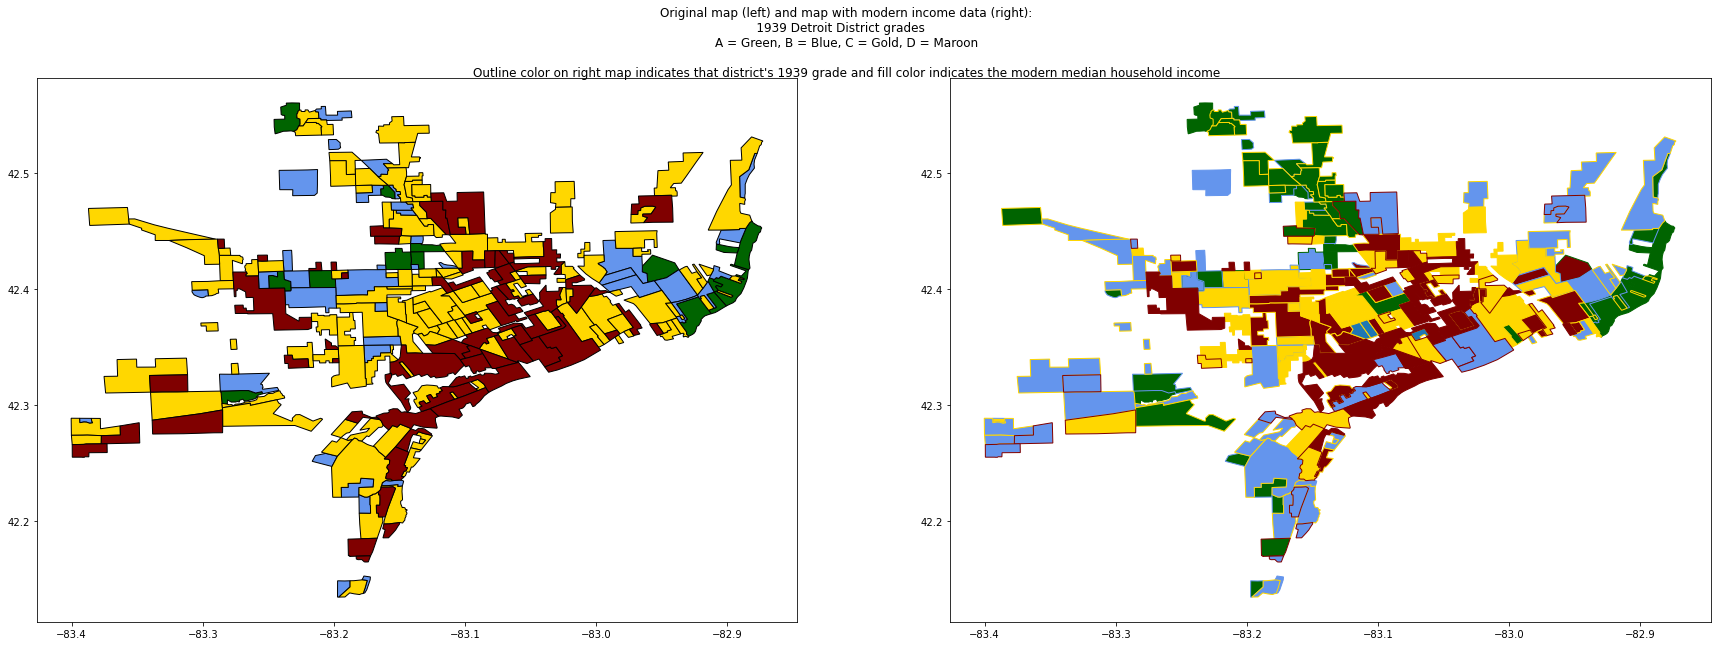

In [24]:
# Plotting the maps side by side
fig, (ax, ax2) = plt.subplots(1, 2)
for dist in Districts:
    ax.add_patch(patches.Polygon(dist.Coordinates, facecolor=dist.HolcColor, \
                                 edgecolor='black'))
    ax.autoscale()
    ax2.add_patch(patches.Polygon(dist.Coordinates, facecolor=dist.IncomeColor,\
                                 edgecolor=dist.HolcColor))
    ax2.autoscale()
plt.suptitle('Original map (left) and map with modern income data (right):\n \
    1939 Detroit District grades\
        \nA = Green, B = Blue, C = Gold, D = Maroon\n \nOutline color on right \
map indicates that district\'s 1939 grade and fill color indicates the \
modern median household income')
plt.rcParams["figure.figsize"] = (30,10)
plt.show()

##### Results

After plotting the map again with the updated income data, we can see that several distiricts have been gentrified; these districts are indentified by having a red outline and a blue fill color. The effects are especially pronounced near Downtown and the surrounding areas. You can also see evidence of higher income families moving to the outer limits of Detroit while looking at the two maps side by side.